In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [4]:
df = pd.read_csv('MovieGenre.csv', encoding = 'latin-1')
df = df.head(1000)

In [5]:
import urllib.request
from PIL import Image
from io import BytesIO

In [6]:
df.drop(columns=[ 'Imdb Link','IMDB Score',], inplace=True)
df.dropna(inplace=True)
df.head(5)


,imdbId,Title,Genre,Poster
0,114709,Toy Story (1995),Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,Jumanji (1995),Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,Grumpier Old Men (1995),Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,Waiting to Exhale (1995),Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,Father of the Bride Part II (1995),Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [7]:
df['Genre'] = df['Genre'].str.split('|')

# Get all unique genres
unique_genres = set()
for genres in df['Genre']:
    unique_genres.update(genres)

for genre in unique_genres:
    df[genre] = df['Genre'].apply(lambda x: 1 if genre in x else 0)

# Drop the original 'Genres' column if needed
df.drop('Genre', axis=1, inplace=True)

df.head(5)

,imdbId,Title,Poster,Sport,Horror,Biography,Family,Crime,History,Animation,...,Short,War,Comedy,Mystery,Action,Romance,Musical,Thriller,Fantasy,Adventure
0,114709,Toy Story (1995),https://images-na.ssl-images-amazon.com/images...,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
1,113497,Jumanji (1995),https://images-na.ssl-images-amazon.com/images...,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,113228,Grumpier Old Men (1995),https://images-na.ssl-images-amazon.com/images...,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,114885,Waiting to Exhale (1995),https://images-na.ssl-images-amazon.com/images...,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,113041,Father of the Bride Part II (1995),https://images-na.ssl-images-amazon.com/images...,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [8]:
df.isnull().sum()

imdbId         0
Title          0
Poster         0
Sport          0
Horror         0
Biography      0
Family         0
Crime          0
History        0
Animation      0
Drama          0
Film-Noir      0
Documentary    0
Music          0
Western        0
Sci-Fi         0
Short          0
War            0
Comedy         0
Mystery        0
Action         0
Romance        0
Musical        0
Thriller       0
Fantasy        0
Adventure      0
dtype: int64

In [9]:
for x in df.columns:
    if x != 'imdbId':
        df.drop(columns={x},inplace=True)
    if x=='imdbId':
        break



In [10]:
df.columns

Index(['imdbId', 'Title', 'Poster', 'Sport', 'Horror', 'Biography', 'Family',
       'Crime', 'History', 'Animation', 'Drama', 'Film-Noir', 'Documentary',
       'Music', 'Western', 'Sci-Fi', 'Short', 'War', 'Comedy', 'Mystery',
       'Action', 'Romance', 'Musical', 'Thriller', 'Fantasy', 'Adventure'],
      dtype='object')

In [11]:
df['Action'].value_counts()

Action
0    845
1    142
Name: count, dtype: int64

In [12]:
data=df.iloc[:,3:]

In [13]:
average_count = data.sum(axis=0).mean()
print(average_count)

102.52173913043478


In [14]:
# uncomment if you don't want to remove the columns below mean

value_counts = df.iloc[:,3:].apply(pd.value_counts)

# Define a threshold for the value counts
threshold = average_count  # Adjust this threshold based on your criteria

# Identify columns where the value counts are below the threshold
columns_to_drop = value_counts.columns[value_counts.min() < threshold]

# Drop the identified columns from the DataFrame
df = df.drop(columns=columns_to_drop)

<Figure size 1000x600 with 0 Axes>

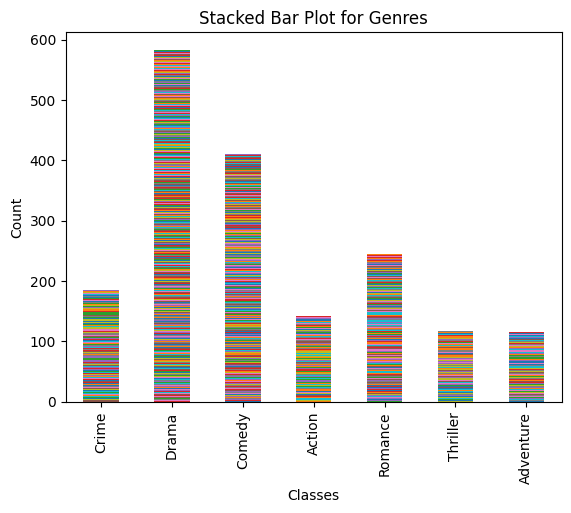

In [15]:
# Heatmap
import matplotlib.pyplot as plt
data=df.iloc[:,3:]

# Stacked Bar Plot
plt.figure(figsize=(10, 6))
data.T.plot(kind='bar', stacked=True)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Stacked Bar Plot for Genres')
plt.xticks(rotation=90)
plt.legend().remove()
#plt.legend(title='Index', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#Preprocessing image and converting them to RGB values and normalizing them

In [16]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Function to preprocess image
def preprocess_image(image_path):
    # Open image
    try:
      with urllib.request.urlopen(image_path) as response:
          data = response.read()
          img = Image.open(BytesIO(data))
    except:
        img = Image.open(image_path)

    # Resize to 224x224 pixels
    img = img.resize((224, 224))
    img = img.convert('RGB')
        # Convert to grayscale
    #img = img.convert('L')
        # Convert image to numpy array
    img_array = np.array(img)
        # Normalize pixel values to [0, 1]
    img_array = img_array / 255.0
        # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array



In [17]:
X = []  # List of preprocessed images
  # List of corresponding genres
for index, row in df.iterrows():
    image_path = row['Poster']  # Assuming 'image_path' contains the file paths of images
    #genre = row[3:]  # Assuming 'genre' contains the genre labels
    try:
      preprocessed_image = preprocess_image(image_path)
      X.append(preprocessed_image)
    except:
       df.drop(df[df['Poster'] == image_path].index, inplace=True)
       pass

In [18]:
y = df.iloc[:,3:].to_numpy()
    #y.append(genre)
print("array denotion")
# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)
print("splitting")
# 2. Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

array denotion
splitting


In [19]:
print(X_train.shape, y_train.shape)

(639, 1, 224, 224, 3) (639, 7)


#Training The Model


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [21]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# Define the VGG19 model with pre-trained weights
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the VGG19 model
for layer in vgg19_model.layers:
    layer.trainable = False

# Create a Sequential model
vgg19_custom_model = Sequential()

# Add the VGG19 model to the custom model
vgg19_custom_model.add(vgg19_model)

# Flatten the output of the VGG19 model
vgg19_custom_model.add(Flatten())

# Add a dense layer with 512 units and relu activation
vgg19_custom_model.add(Dense(512, activation='relu'))

# Add the output layer with 7 units and softmax activation for classification
vgg19_custom_model.add(Dense(7, activation='softmax'))

# Print model summary
vgg19_custom_model.summary()


80134624/80134624 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 32873543 (125.40 MB)
Trainable params: 12849159 (49.02 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [22]:
vgg19_custom_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
def show(image):
    import matplotlib.pyplot as plt

    # Plot the image using Matplotlib
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()

['Crime', 'Drama', 'Comedy', 'Action', 'Romance', 'Thriller', 'Adventure']
Processing file: https://www.kenosha.com/wp-content/uploads/2023/08/et00072466-jjadjvahwx-landscape-copy.png


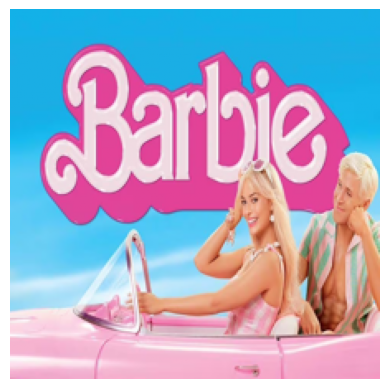

1/1 [==============================] - 1s 1s/step
6 0.3233124017715454 Adventure
5 0.25039446353912354 Thriller
4 0.23232224583625793 Romance
Processing file: https://movies.universalpictures.com/media/opr-tsr1sheet3-look2-rgb-3-1-1-64545c0d15f1e-1.jpg


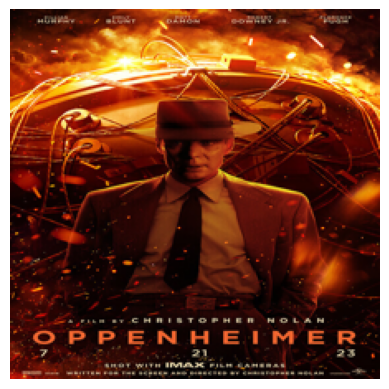

1/1 [==============================] - 1s 687ms/step
5 0.29681506752967834 Thriller
6 0.29066869616508484 Adventure
4 0.19188138842582703 Romance
Processing file: https://media.timeout.com/images/106027003/1024/576/image.webp


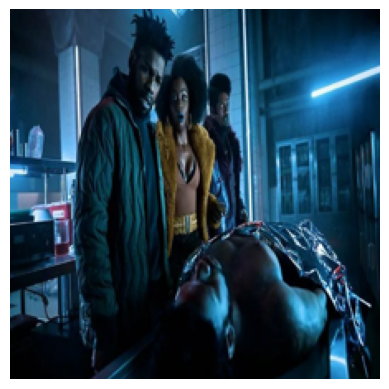

1/1 [==============================] - 1s 679ms/step
5 0.40947407484054565 Thriller
6 0.289263516664505 Adventure
4 0.12447873502969742 Romance


In [24]:
# List of file paths
file4 = r'https://media.timeout.com/images/106027003/1024/576/image.webp'
file2 = r'https://movies.universalpictures.com/media/opr-tsr1sheet3-look2-rgb-3-1-1-64545c0d15f1e-1.jpg'
file1 = r'https://www.kenosha.com/wp-content/uploads/2023/08/et00072466-jjadjvahwx-landscape-copy.png'
#file3 = r'https://theobjectivestandard.com/wp-content/uploads/2022/03/3-Idiots-Written-and-Directed-by-Rajkumar-Hirani-2048x1216.jpg'
file_paths = [file1, file2, file4]  # Add all file paths here

genres = df.iloc[:, 3:].columns.to_list()
print(genres)

# Iterate over each file path
for file_path in file_paths:
    print("Processing file:", file_path)

    # Preprocess the image
    preprocessed_image = preprocess_image(file_path)

    show(preprocessed_image.reshape(224, 224, 3))

    # Make predictions using the VGG19 model
    predictions = vgg19_custom_model.predict(preprocessed_image)
    predictions = predictions.tolist()

    # Process predictions
    classes = []
    for x in predictions:
        for y in x:
            classes.append(y)

    # Print the top 3 predicted genres
    i = 0
    while i != 3:
        print(classes.index(max(classes)), max(classes), genres[classes.index(max(classes))])
        classes[classes.index(max(classes))] = -1000
        i += 1


In [26]:
# Reshape input data
X_train = X_train.reshape(-1, 224, 224, 3)
X_val = X_val.reshape(-1, 224, 224, 3)

# Ensure model is compiled
vgg19_custom_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = vgg19_custom_model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on validation data
val_loss, val_accuracy = vgg19_custom_model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


Epoch 1/2
20/20 [==============================] - 631s 32s/step - loss: 27.3872 - accuracy: 0.3302 - val_loss: 33.1872 - val_accuracy: 0.2188
Epoch 2/2
5/5 [==============================] - 118s 24s/step - loss: 31.6358 - accuracy: 0.4750
Validation Loss: 31.635772705078125
Validation Accuracy: 0.4749999940395355


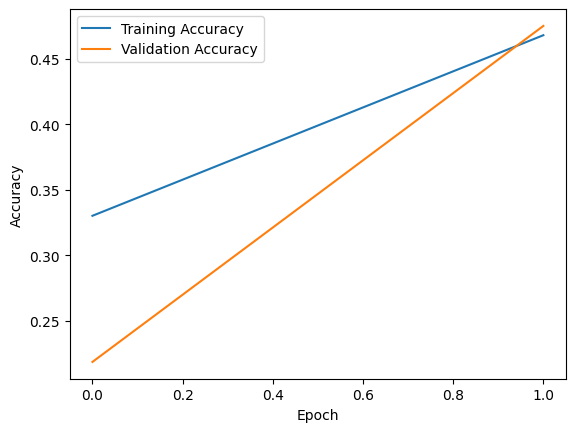

In [27]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


5/5 [==============================] - 121s 24s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.59      1.00      0.75        95
           2       0.00      0.00      0.00        61
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        37
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        27

   micro avg       0.59      0.33      0.43       287
   macro avg       0.08      0.14      0.11       287
weighted avg       0.20      0.33      0.25       287
 samples avg       0.59      0.37      0.44       287

ROC AUC Score: 0.5192310020239965


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


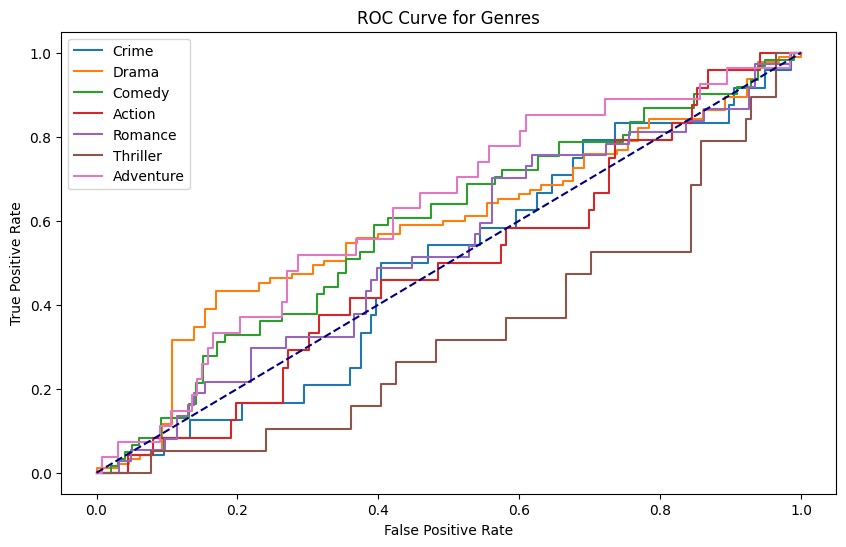

F1 Score: 0.10644257703081232


In [29]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score

# Make predictions on the validation data
y_pred = vgg19_custom_model.predict(X_val)

# Convert predictions to binary form using a threshold
y_pred_binary = (y_pred > 0.5).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred_binary))

# Calculate and print ROC AUC score
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))

# Calculate and plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(len(genres)):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=genres[i])

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Genres')
plt.legend()
plt.show()

# Calculate and print F1 score
print("F1 Score:", f1_score(y_val, y_pred_binary, average='macro'))


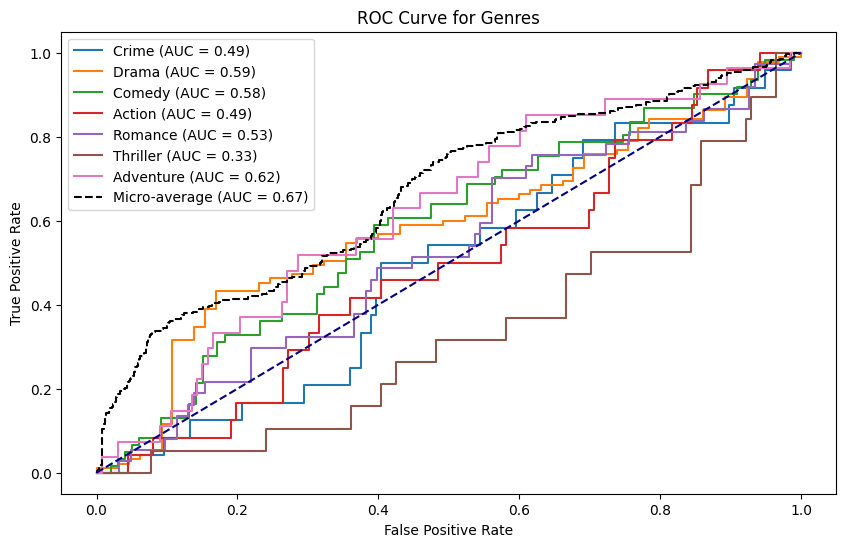

ROC AUC score for Crime: 0.4917279411764706
ROC AUC score for Drama: 0.5863967611336032
ROC AUC score for Comedy: 0.5828779599271402
ROC AUC score for Action: 0.4892769607843137
ROC AUC score for Romance: 0.5282355526257966
ROC AUC score for Thriller: 0.3348264277715566
ROC AUC score for Adventure: 0.621275410749095
Micro-average ROC AUC score: 0.6665342095026165


In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve and ROC AUC score for each class
roc_auc_scores = []
plt.figure(figsize=(10, 6))
for i in range(len(genres)):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc = roc_auc_score(y_val[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'{genres[i]} (AUC = {roc_auc:.2f})')
    roc_auc_scores.append(roc_auc)

# Plot micro-average ROC curve
fpr_micro, tpr_micro, _ = roc_curve(y_val.ravel(), y_pred.ravel())
roc_auc_micro = roc_auc_score(y_val.ravel(), y_pred.ravel())
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle='--', color='black')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Genres')
plt.legend()
plt.show()

# Print ROC AUC scores for each class
for i, genre in enumerate(genres):
    print(f'ROC AUC score for {genre}: {roc_auc_scores[i]}')

# Print micro-average ROC AUC score
print(f'Micro-average ROC AUC score: {roc_auc_micro}')
